In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches


import scipy.io
import scipy.misc

import h5py
import numpy as np
import pandas as pd

import PIL
import math

import tensorflow as tf
from keras import backend as K
from keras.layers import ( Input, Add, Dense, Activation, 
  ZeroPadding2D, BatchNormalization, Flatten, Conv2D, 
  AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D )
  
from keras.models import load_model, Model
from keras.preprocessing import image

from keras.initializers import glorot_uniform

from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN

from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/Colab"

resizedWidth = 384
gridCount = 12





Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'Create Datasets.ipynb'   font			  model_data   yolo_utils.py
 datasets		 'Hair Detection.ipynb'   yad2k


In [0]:
def loadDatasets():
  hf = h5py.File("/content/gdrive/My Drive/Colab/datasets/hairData.h5", "r")
  pixel = np.array(hf.get("hair_data"))
  location = np.array(hf.get("hair_target"))
  hf.close()
  
  trainDataNum = 750
  
  trainingX = pixel[:trainDataNum]
  trainingY = location[:trainDataNum]
  testingX = pixel[trainDataNum:]
  testingY = location[trainDataNum:]
  
  return trainingX, trainingY, testingX, testingY

In [3]:
X_train, Y_train, X_test, Y_test = loadDatasets()
print("X_train shape =", X_train.shape)
print("Y_train shape =", Y_train.shape)
print("X_test shape =", X_test.shape)
print("Y_test shape =", Y_test.shape)

X_train shape = (750, 384, 384, 3)
Y_train shape = (750, 12, 12, 8)
X_test shape = (50, 384, 384, 3)
Y_test shape = (50, 12, 12, 8)


In [4]:
# load existing model weights
yolo_model = load_model("/content/gdrive/My Drive/Colab/model_data/yolo.h5")

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
# modify the final layer
finalLayerOutput = yolo_model.get_layer("leaky_re_lu_22").output
newPredictionLayer = Conv2D(8, (1,1), strides=(1,1), padding = "same", name = "final", kernel_initializer=glorot_uniform(seed = 0))(finalLayerOutput)


firstLayer = yolo_model.get_layer("input_1").input

customModel = Model(firstLayer, newPredictionLayer)
# customModel.summary()


for layer in customModel.layers[:-10]:
  layer.trainable = False
  
  

In [6]:
customModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 384, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 384, 384, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 384, 384, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
# with tf.Session() as sess:
#   x = tf.Variable([1,8,3])
#   y = tf.Variable([7,3,9])
  
#   z = x - y
  
# #   w = tf.Variable([
# #       [1, 8 ,3],
# #       [7, 3, 9]
# #   ])
  
# #   p = tf.reduce_max(w, [0])

#   w = tf.Variable(
#     [6,5,4,3,2,1]
#   )
  
#   o = tf.Variable(
#     [9,1,9,1,9,1]
#   )
  
#   p = K.maximum(w, 0)
  
#   init = tf.global_variables_initializer()
  
#   sess.run(init)
#   print(sess.run(p))

In [0]:
def IOU_loss_confidence(pred_x, pred_y, pred_w, pred_h, 
                        true_x, true_y, true_w, true_h):
  """
  Used for calculating the confidence score between pred_box and true box
  """

  epi = 1e-6
  
  pred_topX = pred_x - pred_w / 2
  pred_topY = pred_y - pred_h / 2
  pred_botX = pred_x + pred_w / 2
  pred_botY = pred_y + pred_h / 2

  true_topX = true_x - true_w / 2
  true_topY = true_y - true_h / 2
  true_botX = true_x + true_w / 2
  true_botY = true_y + true_h / 2
  
  
  xi1 = K.maximum(pred_topX, true_topX)
  yi1 = K.maximum(pred_topY, true_topY)
  
  xi2 = K.minimum(pred_botX, true_botX)
  yi2 = K.minimum(pred_botY, true_botY)
  
  inter_area = K.maximum((yi2 - yi1), 0) * K.maximum((xi2 - xi1), 0)
  
  box1_area = (pred_botX - pred_topX) * (pred_botY - pred_topY)
  box2_area = (true_botX - true_topX) * (true_botY - true_topY)
  union_area = box1_area + box2_area - inter_area + epi
  
  iou = inter_area / union_area

  return iou
  
  

def custom_loss(y_true, y_pred):
  """
  Data Format
  
  12 x 12 x 8
  
  8 = [confidence score, center x, center y, width, height, class1, class2, class3]

  Details of YOLO loss algorithm:
  
  https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088,
  
  https://hackernoon.com/understanding-yolo-f5a74bbc7967

  """
    
  # more weights on bounding box coordinate loss
  alphaCoord = 10
  
  alphaNoObj = 0.5


  positionLoss = 0
  sizeLoss = 0
  localizationLoss = 0
  classificationLoss = 0
  confidenceLoss = 0
  
  trueConf = K.reshape(y_true[:, :, :, 0], [-1])
  trueCenterX = K.reshape(y_true[:, :, :, 1], [-1])
  trueCenterY = K.reshape(y_true[:, :, :, 2], [-1])
  trueWidth = K.reshape(y_true[:, :, :, 3], [-1])
  trueHeight = K.reshape(y_true[:, :, :, 4], [-1])
  trueClass1 = K.reshape(y_true[:, :, :, 5], [-1])
  trueClass2 = K.reshape(y_true[:, :, :, 6], [-1])
  trueClass3 = K.reshape(y_true[:, :, :, 7], [-1])
  
  predConf = K.reshape(y_pred[:, :, :, 0], [-1])
  predCenterX = K.reshape(y_pred[:, :, :, 1], [-1])
  predCenterY = K.reshape(y_pred[:, :, :, 2], [-1])
  predWidth = K.reshape(y_pred[:, :, :, 3], [-1])
  predHeight = K.reshape(y_pred[:, :, :, 4], [-1])
  predClass1 = K.reshape(y_pred[:, :, :,  5], [-1])
  predClass2 = K.reshape(y_pred[:, :, :,  6], [-1])
  predClass3 = K.reshape(y_pred[:, :, :, 7], [-1])
  
  
#   detectedObjectIndices = tf.not_equal(predConf, 0) 
#   undetectedObjectIndices = tf.equal(predConf, 0) 
#   detectedObjectIndices = predConf >= 0.3
#   undetectedObjectIndices = predConf < 0.3
  
  
  responsibleBoxIndices = tf.equal(trueConf, 1) 
  unresponsibleBoxIndices = tf.not_equal(trueConf, 1) 
  
  # class loss
  
  classificationLoss += tf.reduce_sum(K.square(tf.boolean_mask(trueClass1, responsibleBoxIndices) - tf.boolean_mask(predClass1, responsibleBoxIndices)))
  classificationLoss += tf.reduce_sum(K.square(tf.boolean_mask(trueClass2, responsibleBoxIndices) - tf.boolean_mask(predClass2, responsibleBoxIndices)))
  classificationLoss += tf.reduce_sum(K.square(tf.boolean_mask(trueClass3, responsibleBoxIndices) - tf.boolean_mask(predClass3, responsibleBoxIndices)))
  
  # localization loss
    
  positionLoss += alphaCoord * tf.reduce_sum(K.square(tf.boolean_mask(trueCenterX, responsibleBoxIndices) - tf.boolean_mask(predCenterX, responsibleBoxIndices)) + \
                                      K.square(tf.boolean_mask(trueCenterY, responsibleBoxIndices) - tf.boolean_mask(predCenterY, responsibleBoxIndices)))
  sizeLoss += alphaCoord * tf.reduce_sum(K.square(K.sqrt( K.abs(tf.boolean_mask(trueWidth, responsibleBoxIndices)) ) - K.sqrt( K.abs(tf.boolean_mask(predWidth, responsibleBoxIndices))))+ \
                                  K.square(K.sqrt(K.abs( tf.boolean_mask(trueHeight, responsibleBoxIndices))) - K.sqrt(K.abs(tf.boolean_mask(predHeight, responsibleBoxIndices)))))
  localizationLoss += (positionLoss + sizeLoss)
  
  # confidence loss
  
  responsibleIOU = IOU_loss_confidence(
      tf.boolean_mask(predCenterX, responsibleBoxIndices),
      tf.boolean_mask(predCenterY, responsibleBoxIndices),
      tf.boolean_mask(predWidth, responsibleBoxIndices),
      tf.boolean_mask(predHeight, responsibleBoxIndices),
      
      tf.boolean_mask(trueCenterX, responsibleBoxIndices),
      tf.boolean_mask(trueCenterY, responsibleBoxIndices),
      tf.boolean_mask(trueWidth, responsibleBoxIndices),
      tf.boolean_mask(trueHeight, responsibleBoxIndices)
  )
  
  irresponsibleIOU = IOU_loss_confidence(
      tf.boolean_mask(predCenterX, unresponsibleBoxIndices),
      tf.boolean_mask(predCenterY, unresponsibleBoxIndices),
      tf.boolean_mask(predWidth, unresponsibleBoxIndices),
      tf.boolean_mask(predHeight, unresponsibleBoxIndices),
      
      tf.boolean_mask(trueCenterX, unresponsibleBoxIndices),
      tf.boolean_mask(trueCenterY, unresponsibleBoxIndices),
      tf.boolean_mask(trueWidth, unresponsibleBoxIndices),
      tf.boolean_mask(trueHeight, unresponsibleBoxIndices)
  )
  
  confidenceLoss += tf.reduce_sum(K.square(tf.boolean_mask(trueConf, responsibleBoxIndices) - tf.boolean_mask(predConf, responsibleBoxIndices) * responsibleIOU))
  confidenceLoss += alphaNoObj * tf.reduce_sum(K.square(tf.boolean_mask(trueConf, unresponsibleBoxIndices) - tf.boolean_mask(predConf, unresponsibleBoxIndices) * irresponsibleIOU))
  
  finalLoss = classificationLoss + localizationLoss + confidenceLoss
  
  return finalLoss
  
      

In [0]:
custom_adam_optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [0]:
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/Colab/model_data/hairDetection.h5",
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

terminator = TerminateOnNaN()

customModel.compile(optimizer=custom_adam_optimizer, loss=custom_loss, metrics=["accuracy"])

In [0]:
# begin training
customModel.fit(X_train, Y_train, epochs=300, batch_size=32, verbose = 1, validation_split=0.1, callbacks=[terminator, checkpoint])

customModel.save_weights("/content/gdrive/My Drive/Colab/model_data/hairDetection.h5")


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 675 samples, validate on 75 samples
Epoch 1/300
675/675 [==============================] - 22s 33ms/step - loss: 1059.1195 - acc: 0.2132 - val_loss: 738.6608 - val_acc: 0.1600

Epoch 00001: val_loss improved from inf to 738.66076, saving model to /content/gdrive/My Drive/Colab/model_data/hairDetection.h5
Epoch 2/300
675/675 [==============================] - 12s 18ms/step - loss: 453.8770 - acc: 0.1989 - val_loss: 593.5844 - val_acc: 0.0624

Epoch 00002: val_loss improved from 738.66076 to 593.58441, saving model to /content/gdrive/My Drive/Colab/model_data/hairDetection.h5
Epoch 3/300
675/675 [==============================] - 12s 18ms/step - loss: 384.0125 - acc: 0.1587 - val_loss: 496.8000 - val_acc: 0.0592

Epoch 00003: val_loss improved from 593.58441 to 496.79996, saving model to /content/gdrive/My Drive/Colab/model_data/hairDetection.h5
Epoch 4/300
675/675 [==============================] - 12s 18ms/step - loss: 347.7350 - acc: 0.1297 - val_loss: 456.1076 - val_acc: 0.0

In [25]:
# # begin evaluating
preds = customModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print(preds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

50/50 [==============================] - 1s 17ms/step

[259.4438757324219, 0.7902777695655823]
Loss = 259.4438757324219
Test Accuracy = 0.7902777695655823


In [0]:
# customModel.load_weights("/content/gdrive/My Drive/Colab/model_data/hairDetection.h5")
def displayBoundingBoxOnImage(picture, curr):

  # Create figure and axes
  fig,ax = plt.subplots(figsize=(gridCount,10))
  
  # squeeze dimension from (width, height, color) -> (width, height)
#   squeezed = np.squeeze(picture, axis = 2)
  
  # Display the image
#   ax.imshow(squeezed)

  ax.imshow(picture)
  gridSize = resizedWidth // gridCount

  for ygrid in range(gridCount):
    for xgrid in range(gridCount):
      if curr[ygrid][xgrid][0] >= 0.1:
#         print("confidence = " + str(curr[ygrid][xgrid][0]))
#         print("class1 = ", str(curr[ygrid][xgrid][5]))
#         print("class2 = ", str(curr[ygrid][xgrid][6]))
#         print("class3 = ", str(curr[ygrid][xgrid][7]))
#         print(curr[ygrid][xgrid][0] * curr[ygrid][xgrid][5])
#         print(curr[ygrid][xgrid][0] * curr[ygrid][xgrid][6])
#         print(curr[ygrid][xgrid][0] * curr[ygrid][xgrid][7])


        computation1 = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][5]
        computation2 = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][6]
        computation3 = curr[ygrid][xgrid][0] * curr[ygrid][xgrid][7]
      
        score = 0.9
      
        
#         offsetX = xgrid * gridSize
#         offsetY = ygrid * gridSize

#         centerX = curr[ygrid][xgrid][1] * gridSize + offsetX
#         centerY = curr[ygrid][xgrid][2] * gridSize + offsetY

#         width = curr[ygrid][xgrid][3] * resizedWidth
#         height = curr[ygrid][xgrid][4] * resizedWidth

# #         print("Width = ", width)
# #         print("Height = ", height)

#         topX = centerX - width / 2
#         topY = centerY - height / 2

#         # Create a Rectangle patch
#         rect = patches.Rectangle((topX,topY),width,height,linewidth=1,edgecolor='r',facecolor='none')

#         # Add the patch to the Axes
#         ax.add_patch(rect)

        if (computation1 > score or computation2 > score or computation3 > score):
          offsetX = xgrid * gridSize
          offsetY = ygrid * gridSize

          centerX = curr[ygrid][xgrid][1] * gridSize + offsetX
          centerY = curr[ygrid][xgrid][2] * gridSize + offsetY

          width = curr[ygrid][xgrid][3] * resizedWidth
          height = curr[ygrid][xgrid][4] * resizedWidth

  #         print("Width = ", width)
  #         print("Height = ", height)

          topX = centerX - width / 2
          topY = centerY - height / 2

          # Create a Rectangle patch
          rect = patches.Rectangle((topX,topY),width,height,linewidth=1,edgecolor='r',facecolor='none')

          # Add the patch to the Axes
          ax.add_patch(rect)

  plt.show()

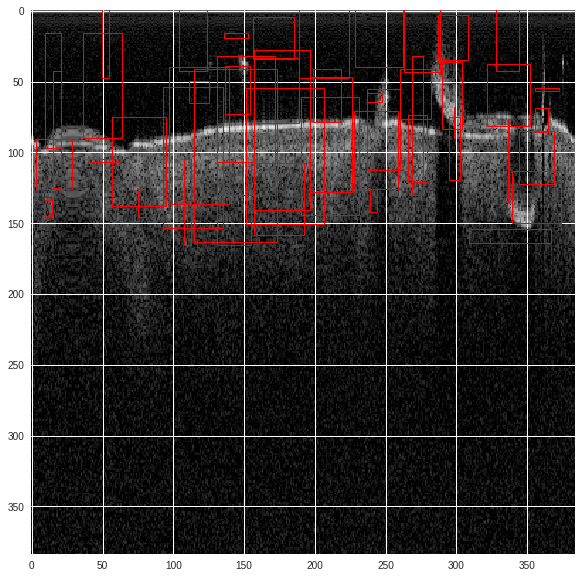

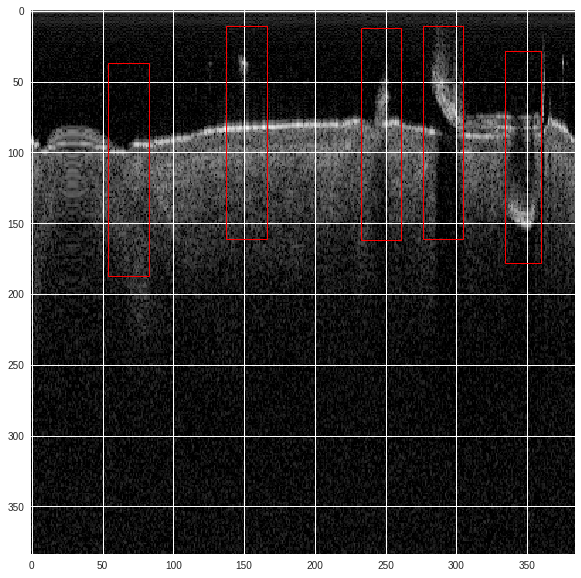

In [27]:
img = X_train[0]
test = np.expand_dims(img, axis = 0)
testRes = customModel.predict(test)

testRes = np.squeeze(testRes, axis = 0)
displayBoundingBoxOnImage(img, testRes)


displayBoundingBoxOnImage(X_train[0], Y_train[0])